In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

# seed 설정
np.random.seed(3)
tf.random.set_seed(3)

In [ ]:
#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # 7*7 초기 이미지 사이즈와 128 개의 노드
generator.add(BatchNormalization()) # 데이터 배치 정규화 실행
generator.add(Reshape((7, 7, 128))) # 합성곱 층에 들어갈 데이터 형태로 변환
generator.add(UpSampling2D()) # 7*7 사이즈를 14*14 로 2배
generator.add(Conv2D(64, kernel_size=5, padding='same')) # 합성곱 padding='same'으로 해서 데이터 손실없이 사이즈 같음
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2))) # LeakyReLU 함수는 ReLu 함수의 0 이하 기울기 소실 문제를 조금 해결
generator.add(UpSampling2D()) # 14*14 를 28*28 사이즈로 변환해 실제 이미지의 사이즈와 동일
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 활성화 함수를 tanh로 데이터 -1~1 값으로 변환
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)       

In [ ]:

#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same")) 
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) # Dense층에 넣어서 판별하기 위해선 2차원 이미지데이터를 1차원으로 변환
discriminator.add(Dense(1, activation='sigmoid')) # 진짜인지 가짜인지 판별
discriminator.compile(loss='binary_crossentropy', optimizer='adam') 
discriminator.trainable = False # 모델이 판별을 하면서 가짜 사진이 학습이 되는 것을 방지
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_5 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [ ]:

#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,)) # 100개의 벡터를 입력
dis_output = discriminator(generator(ginput)) # 생성자를 판별 한 판별값
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [ ]:






#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size) # 0부터 X_train 개수 번호사이 중 batch_size 개를 랜덤으로 불러오기
          imgs = X_train[idx] 
          d_loss_real = discriminator.train_on_batch(imgs, true) # train_on_batch(imgs, true) : 실제 이미지와 true배열을 딱 1번 학습

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100)) # batch_size만큼 100열을 뽑는다
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 
        # 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)



11493376/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7053  g_loss:0.6912
epoch:1  d_loss:0.4626  g_loss:0.3283
epoch:2  d_loss:0.5721  g_loss:0.1035
epoch:3  d_loss:0.6594  g_loss:0.0858
epoch:4  d_loss:0.5762  g_loss:0.1687
epoch:5  d_loss:0.5082  g_loss:0.4277
epoch:6  d_loss:0.4876  g_loss:0.7045
epoch:7  d_loss:0.5092  g_loss:0.8755
epoch:8  d_loss:0.4963  g_loss:0.9019
epoch:9  d_loss:0.4863  g_loss:0.8674
epoch:10  d_loss:0.4168  g_loss:0.7839
epoch:11  d_loss:0.4393  g_loss:0.8035
epoch:12  d_loss:0.4877  g_loss:0.8660
epoch:13  d_loss:0.4947  g_loss:0.9090
epoch:14  d_loss:0.5937  g_loss:0.9227
epoch:15  d_loss:0.4941  g_loss:1.0317
epoch:16  d_loss:0.4145  g_loss:0.9967
epoch:17  d_loss:0.6370  g_loss:0.7927
epoch:18  d_loss:0.5642  g_loss:0.6615
epoch:19  d_loss:0.4512  g_loss:0.7103
epoch:20  d_loss:0.4373  g_loss:0.7269
epoch:21  d_loss:0.4956  g_loss:0.7911
epoch:22  d_loss:0.5026  g_loss:0.6525
epoch:23  d_loss:0.4435  g_loss:0.5941
epoch:24 

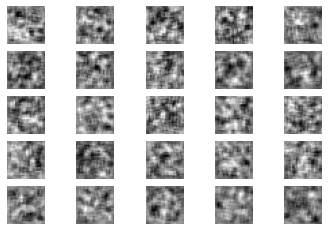

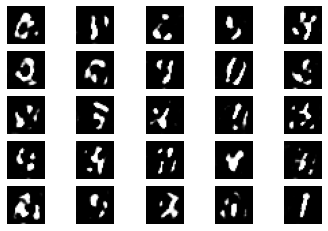

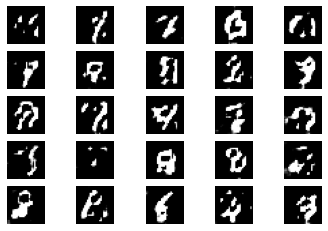

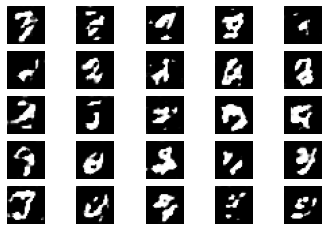

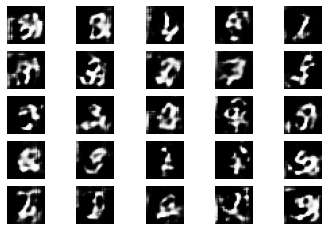

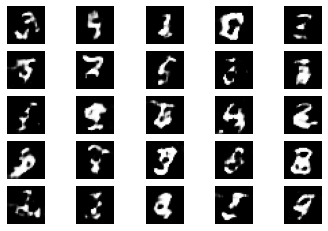

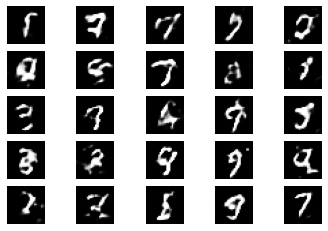

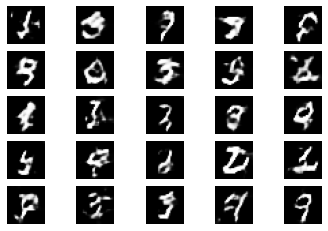

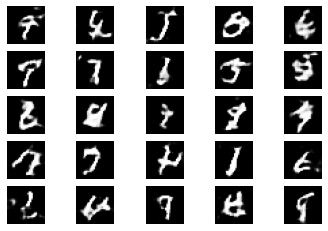

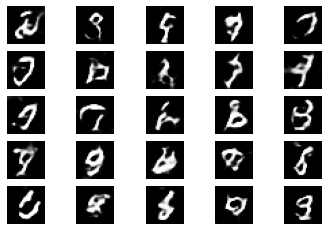

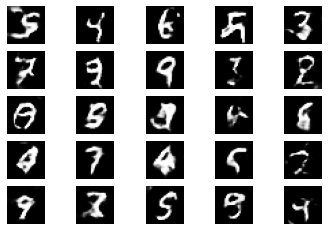

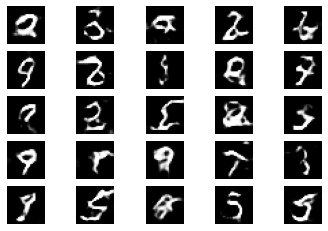

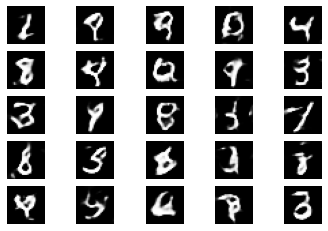

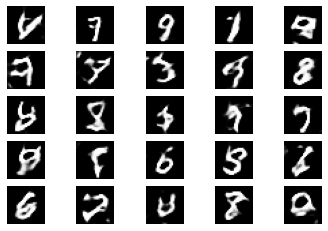

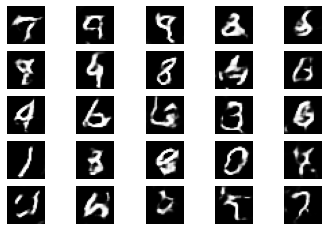

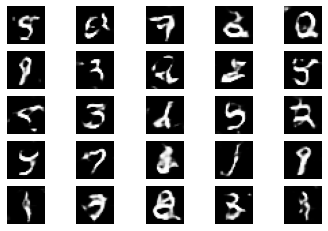

In [ ]:
gan_train(3001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.